In [9]:
import numpy as np
import logging
import decimal
import math
from scipy.fftpack import dct
from scipy.signal.windows import hann
import librosa
import pandas as pd
import os
from tqdm import tqdm

In [10]:
# Round function
def round_half_up(number):
  return int(decimal.Decimal(number).quantize(decimal.Decimal('1'), rounding=decimal.ROUND_HALF_UP))

# Return necessary variables to correlate Greenwood scale with Hertz
def returnValueTuple():
  fmin = 10
  fmax = 10000
  k = 0.88
  A = fmin/(1-k)
  a = math.log10(fmax/A+k)
  return (a,A,k)

# Retreive Greenwood from Hertz
def greenwood_from_hertz(hertz):
  a,A,k = returnValueTuple()
  f = hertz
  return (1/a)*math.log10(f/A+k)

# Retreive Hertz from Greenwood
def hertz_from_greenwood(greenwood):
  a,A,k = returnValueTuple()
  fp = greenwood
  return A*(10**(a*fp)-k)

In [11]:
# NFFT: The size of FFT, It FFT number is less the precision will be less because of dropping many samples; 
#       Using large FFT allows zero padding which is neutral when frequency domain is concerened
#       Here Multiplication by 2 is done which allows some padding but is safe as no sample are dropped 
def calculateNFFTS(sampleRate,windowLength):
  windowLengthSample = windowLength*sampleRate
  nfft = 1
  while nfft < windowLengthSample:
    nfft*=2
  return nfft

# Pre Emphasis: Amplification of high frequencies to balance the frequency spectrum as high frequencies tend to have low magnitude when compared to lower ones
# Formula: x`(n) = x(n) - a*x(n-1) where a = pre-emphasis factor
def preEmphasis(signal,preEmphasisFactor=0.97):
  return np.append(signal[0], signal[1:] - preEmphasisFactor * signal[:-1])

# Numpy stride technique, refer: 
# https://ellisvalentiner.com/post/np-strides-trick/ and
# https://ipython-books.github.io/46-using-stride-tricks-with-numpy/
def rollingWindow(paddedSignal,frameLength,step=1):
    shape = paddedSignal.shape[:-1] + (paddedSignal.shape[-1] - frameLength + 1, frameLength)
    strides = paddedSignal.strides + (paddedSignal.strides[-1],)
    return np.lib.stride_tricks.as_strided(paddedSignal, shape=shape, strides=strides)[::step]

# Cut the signal in frames, frameStep = Number of frames of previous sample after which 2nd sample frames should start, strideTrick uses internal numpy method
def frameSignal(signal, frameLength, frameStep, windowFunction):

  lengthOfSignal = len(signal)
  frameLength = int(round_half_up(frameLength))
  frameStep = int(round_half_up(frameStep))

  if lengthOfSignal < frameLength:
    numberOfFrames = 1
  else:
    numberOfFrames = 1 + int(math.ceil((1.0 * lengthOfSignal - frameLength) / frameStep))

  paddingLength = int((numberOfFrames - 1) * frameStep + frameLength)
  zeros = np.zeros((paddingLength - lengthOfSignal,))
  paddedsignal = np.concatenate((signal, zeros))

  # Use numpy to efficiently make windows
  window = windowFunction(frameLength)
  frames = rollingWindow(paddedsignal,frameLength,step = frameStep)

  return frames * window

# Magnitude Spectrum: Calculated using numpy.fft.rfft' returns the absolute values after taking fourier transfrom
def magSpectrum(frames,nfft):
  if np.shape(frames)[1] > nfft:
    logging.warn('frame length {} is greater than FFT size {}, frame will be truncated. Increase NFFT to avoid.'.format(np.shape(frames)[1],nfft))
  complexSpectrum = np.fft.rfft(frames,nfft)
  return np.absolute(complexSpectrum)

# Power Spectrum: Calulated using 1/n*|si|^2 where 'si' is fourier transform
def powSpectrum(frames,nfft):
  return 1.0/nfft*np.square(magSpectrum(frames,nfft))

# Log power spectrum and normalize: Not needed
def logPowSpectrum(frames,nfft,normalize = 1):
  powerSpectrum = powSpectrum(frames,nfft)
  # If values are close to 0 or 0 log function will have problem
  powerSpectrum[powerSpectrum<= 1e-30] = 1e-30
  logPowerSpectrum = 10*np.log10(powerSpectrum)
  if normalize:
    return logPowerSpectrum - np.max(logPowerSpectrum)
  else:
    return logPowerSpectrum

# Returns Filter Banks: 
# Filters correspond to rows and Columns correspond to fft bins
# returns: array of size = numberOfFilter*(nfft/2+1)
def returnFilterBanks(numberOfFilter=30,nfft=512,sampleRate=16000,lowFrequency=0,highFrequency=None):
  highFrequency= highFrequency or sampleRate/2
  assert highFrequency <= sampleRate/2, "High Frequency is greater than sampleRate/2"

  # Calculate evenly spaced pts in greenwood
  lowGreenWood = greenwood_from_hertz(lowFrequency)
  highGreenWood = greenwood_from_hertz(highFrequency)
  greenWoodPoints = np.linspace(lowGreenWood,highGreenWood,numberOfFilter+2)

  # Current points are in Hertz, but we use fft bins, so we have to convert from Hertz to fft bin number
  bin = np.floor((nfft+1)*hertz_from_greenwood(greenWoodPoints)/sampleRate)

  fbank = np.zeros([numberOfFilter,nfft//2+1])
  for j in range(0,numberOfFilter):
      for i in range(int(bin[j]), int(bin[j+1])):
          fbank[j,i] = (i - bin[j]) / (bin[j+1]-bin[j])
      for i in range(int(bin[j+1]), int(bin[j+2])):
          fbank[j,i] = (bin[j+2]-i) / (bin[j+2]-bin[j+1])
  return fbank

# Array of banpass filters(filters which decide what frequencies can pass)
def filterBank(signal,sampleRate=16000, windowLength=0.025, windowStep=0.01, numberOfFilter=30, nfft=512,
               lowFrequency=0, highFrequency=None, preEmphasisFactor=0.97, windowFunction=lambda x: np.ones((x,))):
  
  highFrequency = highFrequency or sampleRate/2
  
  # Step 1: Apply pre emphasis on signal
  signal = preEmphasis(signal,preEmphasisFactor)

  # Step 2: Frame a signal to overlapping signals: 2d nd array
  frames = frameSignal(signal, windowLength*sampleRate, windowStep*sampleRate, windowFunction)

  # Step 3: Calculate the power spectrum
  powerSpec = powSpectrum(frames,nfft)
  
  # Step 4: Calculate the total energy in each frame
  energy = np.sum(powerSpec,1)
  energy = np.where(energy==0,np.finfo(float).eps,energy)

  # Step 5: Get Filter Banks and its energy
  filterBank = returnFilterBanks(numberOfFilter,nfft,sampleRate,lowFrequency,highFrequency)
  features = np.dot(powerSpec,filterBank.T)
  features = np.where(features==0,np.finfo(float).eps,features)

  return features,energy

# Apply Sinosoidal liftering: Increases the magnitude of highFrequency DCT coefficients
# To de-emphasize higher MFCCs which has been claimed to improve audio detection under noisy circumstances 
def lifter(cepstra,lifterParameter=22):
  L = lifterParameter
  if L > 0:
    nframes,ncoeff = np.shape(cepstra)
    n = np.arange(ncoeff)
    lift = 1 + (L/2.)*np.sin(np.pi*n/L)
    return lift*cepstra
  else:
    return cepstra # No liftering

In [12]:
def gfcc(signal,sampleRate = 16000, windowLength = 0.025, windowStep = 0.01, returnCepstrumNumber = 13, 
         numberOfFilter = 30, nfft = None, lowFrequency = 0, highFrequency = None, preEmphasisFactor = 0.97, 
         lifterParameter = 22, appendEnergy = True, windowFunction = lambda x: np.ones((x,))):
  
  # Step 1: Calculate the length of analysis window
  nfft = nfft or calculateNFFTS(sampleRate,windowLength)

  # Step 2 + 3: Calculate Greenwood Filter Bank and apply to power spectrum
  features, energy = filterBank(signal,sampleRate, windowLength,windowStep, numberOfFilter, nfft, lowFrequency, highFrequency, preEmphasisFactor, windowFunction)

  # Step 4: Take log of features
  features = np.log(features)

  # Step 5: Take discrete fourier transform
  features = dct(features,axis=1,norm='ortho')[:,:returnCepstrumNumber]

  # Step 6: Liftering
  features = lifter(features,lifterParameter)

  # First frame generally defines energy of that frame
  if appendEnergy:
    features[:,0] = np.log(energy)
  
  return features

In [13]:
training_data_path = '../mubin/Data/Training'
testing_data_path = '../mubin/Data/Testing'

In [14]:
# Remove unwanted files

for path in [testing_data_path,training_data_path]:
    for folder in ['Noise','Rumbles']:
        for file in ['.amlignore', '.amlignore.amltmp']:
            if os.path.exists(path+'/'+folder+'/'+file):
                os.remove(path+'/'+folder+'/'+file)
    

## Train and Validation Set

In [15]:
noiseFiles = next(os.walk(training_data_path+'/Noise'))[2]
print(len(noiseFiles))

rumbleFiles = next(os.walk(training_data_path+'/Rumbles'))[2]
print(len(rumbleFiles))

print(len(noiseFiles)==len(rumbleFiles))

3180
3180
True


In [16]:
# 4sec*2000 sr = 8000
target = 8000
targetSampleRate = 2000

def returnGfccCoeff(audio,sample_rate):
    gfccs = gfcc(audio,sample_rate,windowFunction=hann,returnCepstrumNumber=18,preEmphasisFactor=0,lifterParameter=0,lowFrequency=10,highFrequency=500,windowLength=0.075,windowStep=0.025)
    return gfccs
    
def preProcess(fileName,ar,fileType):
    audio,sample_rate = librosa.load(fileName,sr=targetSampleRate)
    if len(audio)>=target:
        newAudio = audio[:target]
        ar.append([returnGfccCoeff(newAudio,targetSampleRate),fileType])
    elif len(audio)>=4000:
        newAudio = np.append(audio,np.zeros(target-len(audio)))
        ar.append([returnGfccCoeff(newAudio,targetSampleRate),fileType])
    
noise_set_size = len(noiseFiles)
rumble_set_size = len(rumbleFiles)
noiseList = [['Noise/noise_'+str(i)+'.wav',0] for i in range(1,noise_set_size+1)]
rumbleList = [['Rumbles/rumble_'+str(i)+'.wav',1] for i in range(1,rumble_set_size+1)]
finalList = noiseList+rumbleList
    
preProcessedTrainFiles = []
for i in tqdm(finalList):
    filePath = i[0]
    fileType = i[1]
    fileName = training_data_path+'/'+filePath
    preProcess(fileName,preProcessedTrainFiles,fileType)
    

100%|██████████| 6360/6360 [10:32<00:00, 10.06it/s]


In [35]:
extracted_features_df=pd.DataFrame(preProcessedTrainFiles,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[[-4.353478744308409, 8.847299193587524, 3.689...",0
1,"[[-5.1132014529120475, 4.239382867939322, 0.93...",0
2,"[[-4.634898580352101, 6.435720899107354, 4.121...",0
3,"[[-4.912678649511506, 8.761000676590456, 2.236...",0
4,"[[-4.104406307550257, 8.320791089854463, 3.938...",0


In [36]:
extracted_features_df.apply(lambda row: row['feature'].shape,axis=1).value_counts()

(158, 18)    6054
dtype: int64

In [37]:
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [38]:
print(X.shape,y.shape)

(6054, 158, 18) (6054,)


In [39]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=0, stratify=y)

In [22]:
# from tensorflow.keras.utils import to_categorical
# from sklearn.preprocessing import LabelEncoder

# labelencoder=LabelEncoder()
# y_train = to_categorical(labelencoder.fit_transform(y_train))

In [41]:
y_train

array([1, 0, 1, ..., 0, 1, 0])

In [40]:
print(X_train.shape,y_train.shape)

(4843, 158, 18) (4843,)


In [24]:
# y_val = to_categorical(labelencoder.transform(y_val))

In [42]:
print(X_val.shape,y_val.shape)

(1211, 158, 18) (1211,)


In [43]:
X_train = X_train.reshape(-1,X_train.shape[1],X_train.shape[2],1)

X_val = X_val.reshape(-1,X_val.shape[1],X_val.shape[2],1)

In [44]:
print(X_train.shape,y_train.shape)

(4843, 158, 18, 1) (4843,)


In [45]:
print(X_val.shape,y_val.shape)

(1211, 158, 18, 1) (1211,)


## Test Set

In [29]:
noiseTestFiles = next(os.walk(testing_data_path+'/Noise'))[2]
print(len(noiseTestFiles))

rumbleTestFiles = next(os.walk(testing_data_path+'/Rumbles'))[2]
print(len(rumbleTestFiles))

print(len(noiseTestFiles)==len(rumbleTestFiles))

757
757
True


In [52]:

noise_test_set_size = len(noiseTestFiles)
rumble_test_set_size = len(rumbleTestFiles)

noiseTestList = [['Noise/noise_'+str(i)+'.wav',0] for i in range(1,noise_test_set_size+1)]
rumbleTestList = [['Rumbles/rumble_'+str(i)+'.wav',1] for i in range(1,rumble_test_set_size+1)]

finalTestList = noiseTestList+rumbleTestList
    
preProcessedTestFiles = []
for i in tqdm(finalTestList):
    filePath = i[0]
    fileType = i[1]
    fileName = testing_data_path+'/'+filePath
    preProcess(fileName,preProcessedTestFiles,fileType)
    

100%|██████████| 1514/1514 [02:23<00:00, 10.56it/s]


In [53]:
extracted_test_features_df = pd.DataFrame(preProcessedTestFiles,columns=['feature','class'])
extracted_test_features_df.head()

,feature,class
0,"[[-5.0897777786499985, 3.8598030465252444, 1.6...",0
1,"[[-4.6996006670551616, 7.3385415086445285, 1.8...",0
2,"[[-5.3567076987659465, 5.48035718638847, 5.174...",0
3,"[[-3.577061882726914, 2.1885531707106054, 0.56...",0
4,"[[-3.911528384184917, 0.6352179563304279, 0.77...",0


In [54]:
extracted_test_features_df.apply(lambda row: row['feature'].shape,axis=1).value_counts()

(158, 18)    1462
dtype: int64

In [55]:
X_test=np.array(extracted_test_features_df['feature'].tolist())
y_test=np.array(extracted_test_features_df['class'].tolist())

In [56]:
# y_test = to_categorical(labelencoder.transform(y_test))

In [57]:
X_test = X_test.reshape(-1,X_test.shape[1],X_test.shape[2],1)

In [58]:
print(X_test.shape,y_test.shape)

(1462, 158, 18, 1) (1462,)


## Model

In [47]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [48]:
model = Sequential()

model.add(Conv2D(64, kernel_size=3, input_shape=X_train.shape[1:] ))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=3))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dense(1, activation='sigmoid'))

In [49]:
model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 156, 16, 64)       640       
_________________________________________________________________
batch_normalization (BatchNo (None, 156, 16, 64)       256       
_________________________________________________________________
activation (Activation)      (None, 156, 16, 64)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 78, 8, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 76, 6, 32)         18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 76, 6, 32)         128       
_________________________________________________________________
activation_1 (Activation)    (None, 76, 6, 32)         0

In [51]:
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping

num_epochs = 100
num_batch_size = 32


earlystopping = EarlyStopping(monitor ="val_loss", mode ="min", patience = 5, restore_best_weights = True)

start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs,callbacks=[earlystopping], validation_data=(X_val, y_val), verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 4843 samples, validate on 1211 samples
Epoch 1/100
4843/4843 [==============================] - 13s 3ms/sample - loss: 0.1792 - accuracy: 0.9393 - val_loss: 0.2300 - val_accuracy: 0.9604
Epoch 2/100
4843/4843 [==============================] - 12s 2ms/sample - loss: 0.0892 - accuracy: 0.9738 - val_loss: 0.1414 - val_accuracy: 0.9472
Epoch 3/100
4843/4843 [==============================] - 12s 2ms/sample - loss: 0.0637 - accuracy: 0.9827 - val_loss: 0.0861 - val_accuracy: 0.9727
Epoch 4/100
4843/4843 [==============================] - 12s 2ms/sample - loss: 0.0443 - accuracy: 0.9872 - val_loss: 0.3062 - val_accuracy: 0.9216
Epoch 5/100
4843/4843 [==============================] - 20s 4ms/sample - loss: 0.0268 - accuracy: 0.9938 - val_loss: 0.0921 - val_accuracy: 0.9711
Epoch 6/100
4843/4843 [==============================] - 20s 4ms/sample - loss: 0.0296 - accuracy: 0.9915 - val_loss: 0.4376 - val_accuracy: 0.9125
Epoch 7/100
4843/4843 [==============================] - 20s 4ms

In [141]:
test_accuracy = model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.94391245


In [142]:
y_preds = model.predict(X_test)

In [143]:
y_preds

array([[0.08837481],
       [0.00138085],
       [0.02319771],
       ...,
       [0.22247593],
       [0.97695667],
       [0.16806886]], dtype=float32)

In [144]:
import copy
y_preds = y_preds.ravel()
y_predsCopy = copy.deepcopy(y_preds)

In [145]:
y_preds

array([0.08837481, 0.00138085, 0.02319771, ..., 0.22247593, 0.97695667,
       0.16806886], dtype=float32)

In [146]:
for i, predicted in enumerate(y_preds):
    if predicted >= 0.45:
        y_preds[i] = 1
    else:
        y_preds[i] = 0

In [147]:
y_preds

array([0., 0., 0., ..., 0., 1., 0.], dtype=float32)

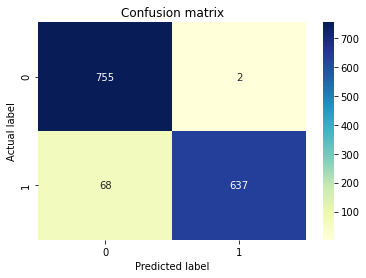

In [148]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

cnf_matrix = confusion_matrix(y_test,y_preds)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [157]:
for idx,val in enumerate(y_test):
    if val == 1 and y_preds[idx]==0:
        print(y_predsCopy[idx],end="\t")

0.2742829	0.07963225	0.15416084	0.40476352	0.16475208	0.33369458	0.27135807	0.37198845	0.15812393	0.003445824	0.41762635	0.39813715	0.114097536	0.03775068	0.0667372	0.00010670059	0.0024348893	0.21006943	0.35622916	0.079353906	0.047483586	0.3806984	0.3687393	0.43736675	0.21376282	0.27848136	0.2639734	0.33975077	0.13510388	0.42120498	0.06046257	0.15565032	0.23499042	0.3992322	0.30454296	0.4054947	0.17409709	0.20253353	0.10266082	0.340481	0.1261971	0.3644492	0.20860822	0.20210427	0.34090954	0.02563282	0.440271	0.18574414	0.14915752	0.2646743	0.2049423	0.119007304	0.19675094	0.16191126	0.08933467	0.053648923	0.19655761	0.42692906	0.1967213	0.3511195	0.31432614	0.05834043	0.2033456	0.03472584	0.3421278	0.15047456	0.22247593	0.16806886	

In [150]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       757
           1       1.00      0.90      0.95       705

    accuracy                           0.95      1462
   macro avg       0.96      0.95      0.95      1462
weighted avg       0.96      0.95      0.95      1462



In [153]:
modelSavingPath = 'saved_models/elephant_rumble_model_1.h5'
if os.path.isfile(modelSavingPath) is False:
    model.save(modelSavingPath)

In [154]:
modelJsonSavingPath = 'saved_models/elephant_rumble_json_architecture_1.json'

# serialize model to json
json_model = model.to_json()

#save the model architecture to JSON file
with open(modelJsonSavingPath, 'w') as json_file:
    json_file.write(json_model)